## Tensorflow Linear Model a comparison of three optimizers

## Optimizers

1. AdagradOptimizer
2. GradientDescentOptimizer
3. AdamOptimizer

## AdagradOptimizer has a slightly higher accuracy than the other two refer line[41]

* The original author of this code is Magnus Erik Hvass Pedersen and I have only investigated the the performances of the three optimizers by changing the batch_size,number of iterations, learning rate and the optimizer. The results are given in line [41]. Thanks to Magnus Erik Hvass Pedersen for making the Tensorflow code opensource.
* Originial code can be downloaded from https://github.com/Hvass-Labs/TensorFlow-Tutorials.git
* Code was developed using Anaconda Python 3.x ,Jupyter Notebook, GPU NVIDIA GeForce GTX 780M
* This experiment was done to investigate the performances of the three optimizers.
* Hope it helps others.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix


In [2]:
## Load Data MNIST

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST",one_hot=True)     

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [4]:
print("Set of data:")
print("-Traning-set:\t\t{}".format(len(data.train.labels)))
print("-Testing-set:\t\t{}".format(len(data.test.labels)))
print("-Validation-set:\t\t{}".format(len(data.validation.labels)))

Set of data:
-Traning-set:		55000
-Testing-set:		10000
-Validation-set:		5000


## One Hot encoding

The dataset has been loaded as one hot encoding

In [5]:
data.test.labels[0:5,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

## Data dimension

In [8]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size,img_size)
num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

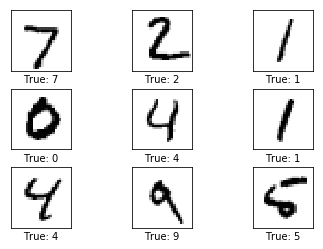

In [10]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images,cls_true=cls_true)

## Tensorflow Graph


In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))



In [16]:
logits = tf.matmul(x, weights) + biases

In [17]:
y_pred = tf.nn.softmax(logits)

In [18]:
y_pred.shape

TensorShape([Dimension(None), Dimension(10)])

In [19]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [20]:
y_pred_cls.shape

TensorShape([Dimension(None)])

## Cost function to be optimized

In [21]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

In [22]:
cost = tf.reduce_mean(cross_entropy)

In [23]:
optimizer = tf.train.AdagradOptimizer(learning_rate=0.35).minimize(cost)

In [24]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [25]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Tensorflow run

In [26]:
session = tf.Session()

In [27]:
session.run(tf.global_variables_initializer())

In [28]:
batch_size = 500

In [29]:
def optimize(num_iterations):
    for i in range(num_iterations):
      
        x_batch, y_true_batch = data.train.next_batch(batch_size)
       
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

In [30]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [31]:
def print_accuracy():
   
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [32]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [33]:
def plot_example_errors():
   
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [34]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
           
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

In [35]:
print_accuracy()

Accuracy on test-set: 9.8%


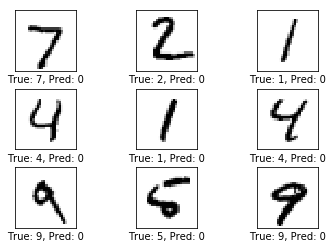

In [36]:
plot_example_errors()


In [37]:
optimize(num_iterations=1)

In [38]:
print_accuracy()

Accuracy on test-set: 38.6%


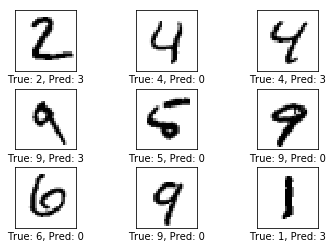

In [39]:
plot_example_errors()

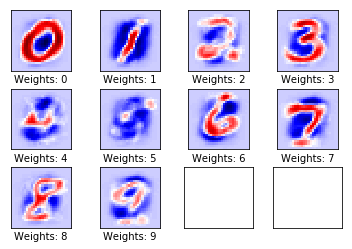

In [40]:
plot_weights()

## Performance after 1500 optimiztion iterations

In [41]:
optimize(num_iterations=1499)

In [42]:
print_accuracy()


Accuracy on test-set: 92.4%


## Impact on accuracy based on different Optimizers and parameters

## AdagradOptimizer
* Optimizer = AdagradOptimizer
* Iteration = 1500
* Batch size = 500
* Learning rate = 0.35
* Accuracy = 92.4%

## GradientDescentOptimizer

* Optimizer = GradientDescentOptimizer
* Iteration = 1500
* Batch size = 500
* Learning rate = 0.35
* Accuracy = 92.1%

## AdaOptimizer

* Optimizer = AdamOptimizer
* Iteration = 1500
* Batch size = 500
* Learning rate = 0.35
* Accuracy = 89.3%


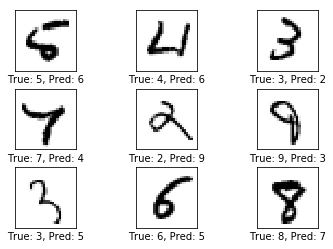

In [43]:
plot_example_errors()

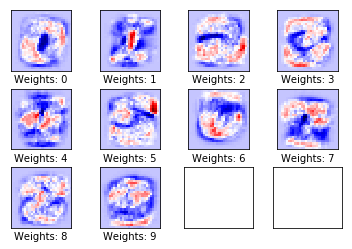

In [44]:
plot_weights()

[[ 962    0    1    2    0    5    8    1    1    0]
 [   0 1111    4    1    0    1    4    2   12    0]
 [   7    9  926   10    8    5   14    9   36    8]
 [   3    1   24  895    0   43    3   11   22    8]
 [   1    2    4    1  917    0   12    4    9   32]
 [   8    2    5   21    9  799   16    4   23    5]
 [  10    3    6    1    9   19  906    2    2    0]
 [   2    7   24    7    9    1    0  943    2   33]
 [   6   10    7   15    9   40   10   10  861    6]
 [  11    8    1    8   26    8    0   20    8  919]]


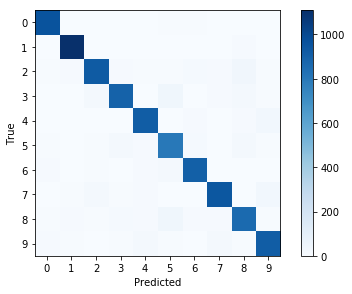

In [45]:
print_confusion_matrix()

In [46]:
session.close()

## Done with Tensorflow Linear model predictions